## Goal:
Build a Random Forest model to predict Recommended vs Not-Recommended classification using text from customer reviews.

In [1]:
# library imports
import pandas as pd
import opendatasets
import contractions
from autocorrect import Speller
from tqdm.notebook import tqdm_notebook
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download(info_or_id='stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import spacy
import re

# initiate tqdm for pandas.apply() functions
tqdm_notebook.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#expand notebook display options for dataframes
pd.set_option('display.max_colwidth', 200)
pd.options.display.max_columns = 999
pd.options.display.max_rows = 300

## Dataset Import 

In [3]:
# option to use opendatasets to directly retrieve the dataset from Kaggle
kaggle_url = 'https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews'
opendatasets.download(kaggle_url)

In [4]:
dataset = pd.read_csv('dataset\\Womens Clothing E-Commerce Reviews.csv')

In [5]:
dataset.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comfortable,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length...",5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i co...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,5,1,6,General,Tops,Blouses


## Text Pre-processing

In [6]:
# drop any rows with missing Review Text
dataset.dropna(axis=0, how='any', subset=['Review Text'], inplace=True)

In [7]:
# make all characters uniformly lowercase in order to ignoring case
dataset['Review Text'] = dataset['Review Text'].apply(lambda x: x.lower())

In [8]:
def cont_expand(text):
    """
    Expand contractions (i.e don't->do not, can't->cannot)
    """
    expanded_text = contractions.fix(text, slang=False)
    return expanded_text

# expand contractations
dataset['Review Text'] = dataset['Review Text'].progress_apply(cont_expand)

In [9]:
def clean_slang_terms(text): 
    """
    Correct common slang and abbreviations
    """
    text = re.sub(r"\babt?\b", "about", text)
    text = re.sub(r"\brll?y\b", "really", text)
    text = re.sub(r"\brn\b", "right now", text)
    text = re.sub(r"\bwanna\b", "want to", text)
    text = re.sub(r"\besp\b", "especially", text)
    text = re.sub(r"\bmed\b", "medium", text)
    text = re.sub(r"\bgonn[ao]\b", "going to", text)
    text = re.sub(r"\btho\b", "though", text)
    text = re.sub(r"altho ", "although ", text)
    text = re.sub(r"prolly", "probably", text)
    text = re.sub(r"asap", "as soon as possible", text)
    text = re.sub(r"\bbc|b/c\b", "because", text)
    text = re.sub(r"\bavail\b", "available", text)
    text = re.sub(r"\bdiff\b", "different", text)
    text = re.sub(r"\bnxt|enxt\b", "next", text)
    text = re.sub(r" w/ ", " with ", text)
    text = re.sub(r"\bmsg\b", "message", text)
    text = re.sub(r"\bdidn ", "didn't ", text)
    text = re.sub(r" dnt ", " don't ", text)
    text = re.sub(r"\bsnd\b", "send", text)
    text = re.sub(r"b4\b", "before", text)
    text = re.sub(r"\batm\b", "at the moment", text)
    text = re.sub(r"\besp\b", "especially", text)
    text = re.sub(r"\bavg\b", "average", text)
    text = re.sub(r" {2,}", " ", text).strip() 

    return text

In [10]:
dataset['Review Text'] = dataset['Review Text'].progress_apply(clean_slang_terms)

  0%|          | 0/22641 [00:00<?, ?it/s]

In [11]:
# autocorrect any misspelled words (takes about ~20 minutes)
spell_check = Speller(lang='en')
dataset['Review Text'] = dataset['Review Text'].progress_apply(lambda x: spell_check(str(x)))

In [12]:
# remove everything other than letters and apostrophes, and replace the removed with a space 
# (^ characher indicates to complement the input)
dataset['Review Text'] = dataset['Review Text'].apply(lambda x: re.sub(pattern=r'[^a-z\']', repl=' ', string=x))

# remove any extra whitespace within the text
dataset['Review Text'] = dataset['Review Text'].apply(lambda x: re.sub(pattern=r'\s{2,}', repl=' ', string=x))

In [13]:
# manually edit the list of stopwords by removing certain important words
to_remove = ["not", "no", "but", "own", "more", "over", "under", "most", "again"]
new_stopwords  = set(stopwords.words('english')) - set(to_remove) 

In [14]:
def stemming(text):
    """
    Strip suffixes from a word and return the stem.
    It is inefficient to have the algorithm process multiple formats of a word.
    Ex: loved, loving, or loves ===> love
    """
    # creating an object of the PorterStemmer class
    ps = PorterStemmer()

    stemmed_review = [ps.stem(word) for word in text.split(' ') if word not in set(stopwords.words("english"))]
    return ' '.join(stemmed_review)

In [15]:
# keeping root words with a stemming algorithm (takes about ~5 minutes)
dataset['Review Text'] = dataset['Review Text'].progress_apply(stemming)

  0%|          | 0/22641 [00:00<?, ?it/s]

In [17]:
# lemmatize reviews with spacy
nlp_lem = spacy.load('en_core_web_sm')

def lemmentization(text):
    doc = nlp_lem(u"{}".format(text))
    output = " ". join([token.lemma_ for token in doc])
    return output

In [18]:
# apply lemmentization (takes about ~10 minutes)
dataset['Review Text'] = dataset['Review Text'].progress_apply(lemmentization)

  0%|          | 0/22641 [00:00<?, ?it/s]

## Resampling

In [19]:
from sklearn.utils import resample

In [20]:
# define a random state for reproducible results
random_state = 42

# upsample the minority class ('not-recommended') by duplicating random samples
# 1 = recommended
# 0 = not-recommended
up_sample = resample(dataset[dataset['Recommended IND']==0],
                    replace = True, # sample with replacement
                    n_samples = 10000, # to match majority class
                    random_state = random_state) # set reproducible results

In [21]:
# combine the up-sampled minority class with the rest of the data
dataset_balanced = pd.concat([dataset[dataset['Recommended IND']!=0], up_sample])

In [22]:
print('Before:')
print(dataset['Recommended IND'].value_counts(), '\n')

print('After:')
print(dataset_balanced['Recommended IND'].value_counts())

Before:
1    18540
0     4101
Name: Recommended IND, dtype: int64 

After:
1    18540
0    10000
Name: Recommended IND, dtype: int64


## TF-IDF

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [24]:
# define the corpus
corpus = dataset['Review Text']

# max_feature helps condense the sparse matrix by keeping only the top n number of words in the corpus' vocabulary
# in this case, the 1500 most frequent words are kept
cv = TfidfVectorizer(max_features=1500)

# create the matrix
X = cv.fit_transform(corpus).toarray() 

# adding the dependent variable [recommended (1) vs not-recommended (0)]
y = dataset['Recommended IND'].values

## Train/Test Split

In [25]:
# splitting the dataset into an 80% training and 20% test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=0, 
                                                    shuffle=True)

## Grid-Search

In [26]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()

In [27]:
from sklearn.model_selection import GridSearchCV

parameters = [{'criterion': ['gini','entropy'],
               'n_estimators': [1, 10, 50, 100, 300],
               #'max_depth': [2, 3, 4, 5], 
               #"min_samples_leaf":[1, 5, 10], 
               #"min_samples_split" : [2, 4, 10, 12, 16]
              }]

In [28]:
# determine which combination of parameters leads to the best results
grid_search = GridSearchCV(estimator=classifier, 
                           param_grid=parameters, 
                           scoring='accuracy')

grid = grid_search.fit(X_train, y_train)

print('Best accuracy: {}'.format(grid.best_score_))
print('Best parameters: {}'.format(grid.best_params_))

Best accuracy: 0.8616938563411592
Best parameters: {'criterion': 'gini', 'n_estimators': 50}


## Random Forest

In [29]:
# fit the optimized Random Forest model onto the training set
classifier = RandomForestClassifier(n_estimators=50, 
                                    criterion='gini', 
                                    random_state=random_state)
classifier.fit(X_train, y_train)

# predict the test results
y_pred = classifier.predict(X_test)

## Model Metrics

In [30]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, plot_confusion_matrix, plot_roc_curve

In [32]:
# metrics
print("Accuracy:".ljust(18), round(accuracy_score(y_test, y_pred),2))
print("Recall Score:".ljust(18), round(recall_score(y_test, y_pred),2))
print("Percision Score:".ljust(18), round(precision_score(y_test, y_pred),2))
print("F1-Score:".ljust(18), round(f1_score(y_test, y_pred),2))

Accuracy:          0.85
Recall Score:      0.98
Percision Score:   0.85
F1-Score:          0.91


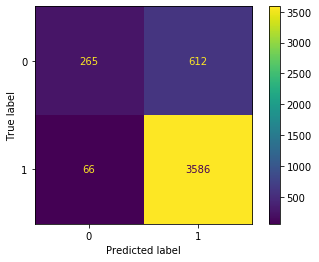

In [33]:
# confusion matrix
plot_confusion_matrix(classifier, X_test, y_test)

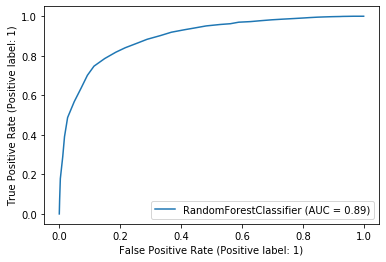

In [34]:
# ROC curve
plot_roc_curve(classifier, X_test, y_test)

## Save the Model

In [35]:
import pickle

In [36]:
# save the model to disk
filename = "optimized_random_forest.sav"
pickle.dump(classifier, open(filename, 'wb'))